In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
from pathlib import Path
import os
from os.path import getsize
import time
import json
import csv
import re
import tiktoken
import openai

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
msdb_path = Path('Movie-Script-Database/scripts')
charinfo_path = Path('Movie-Script-Database/scripts/parsed/charinfo')
dialogue_path = Path('/Movie-Script-Database/scripts/parsed/dialogue')
clean_path = Path('Movie-Script-Database/scripts/clean')
embedding_path = Path('Movie-Script-Database/scripts/embedding')

In [40]:
def clear_text(sentence, rmpunc, rmsw):
    
    sentence = sentence.lower()
    sentence = re.sub("\d+", "", sentence)

    # punctuation
    if rmpunc == True:
        sentence = re.sub(r'[^\w\s]', ' ', sentence)
        sentence = re.sub(r'\b[a-zA-Z]\b', '', sentence)

    # stopwords
    if rmsw == True:
        sentence = remove_stopwords(sentence)

    sentence = ' '.join([w for w in sentence.split(' ') if w != ''])

    return sentence

In [185]:
def pick_main_char(pair):
    threshold = np.quantile(list(line_num.values()), .95)
    key, value = pair
    if value >= threshold:
        return True  # filter pair out of the dictionary
    else:
        return False  # keep pair in the filtered dictionary

In [6]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
#     encoding = tiktoken.get_encoding("cl100k_base")
    encoding = tiktoken.encoding_for_model("text-embedding-ada-002")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [165]:
def save_clean_json_file(dialogue):
    print(f'saving {movie_name}_clean at {time.ctime()}', end = '\n\n')
    jsonFile = open(clean_path / f'{movie_name}_clean.json','w')
    w = json.dumps(dialogue)
    jsonFile.write(w)
    jsonFile.close()

In [ ]:
# # if the script is too long, split it into multiple parts
# token = num_tokens_from_string(dialogue[movie_name][char]['clean_line'][0])
# thr = 8000

# if token > thr:
#     print(f'huge script: {char} in {movie_name}')

#     ori_clean_line = dialogue[movie_name][char]['clean_line'][0]    
#     print(len(ori_clean_line.split(' ')))

#     parts = token // thr + 1
#     cut_at = round(token / parts)
#     p = 0

#     while p < parts:
#         dialogue[movie_name][char]['clean_line'][line_idx] = ori_clean_line.split(' ')[p * cut_at: (p + 1)* cut_at]
#         p += 1
#         line_idx += 1

#     p = 0
#     line_idx = 0
    
# check = 0
# for n in range(0, len(dialogue[movie_name][char]['clean_line'].keys())):
#     check += len(dialogue[movie_name][char]['clean_line'][n])
# print(check)

## clean the text

In [188]:
total_tokens = 0
for file in charinfo_path.glob(f'*charinfo*'):
    print(f'opening {file.stem} at {time.ctime()}')
    
    with open(file) as cf:
        movie_name = file.stem.split('_')[0]
        line_num = {}
        data = cf.readlines()
        for row in data:
            line = row.replace('\n', '').split(': ')
            line_num.update({line[0]: int(line[-1])})

        main_char_line_num = dict(filter(pick_main_char, line_num.items()))
        main_char_line_num = dict(sorted(main_char_line_num.items(), key=lambda x:x[1], reverse=True))
    
    for file in dialogue_path.glob(f'*{movie_name}_dialogue*'):
        size = os.path.getsize(file)
        if size > 1024 * 5:
            print(f'opening {file.stem} at {time.ctime()}')

            with open(file) as df:
                dialogue = {movie_name:{}}
                data = df.readlines()
                
                # gather raw lines
                for row in data:
                    line = row.replace('\n', '').split('=>')
                    char = line[0]
                    raw_line = line[-1]

                    if char in main_char_line_num.keys():
                        if char not in dialogue[movie_name].keys():
                            dialogue[movie_name].update({
                                char: {
                                    'raw_line': raw_line,
                                    'clean_line': {}
                                }
                            })
                            
                        else:
                            dialogue[movie_name][char]['raw_line'] += raw_line
                
                # clear lines
                for char in dialogue[movie_name].keys():
                    dialogue[movie_name][char]['clean_line'] = clear_text(dialogue[movie_name][char]['raw_line'], True, True)
                    token = num_tokens_from_string(dialogue[movie_name][char]['clean_line'])
                    total_tokens += token
                    
                save_clean_json_file(dialogue)
                
#     break

opening Unknown_charinfo at Wed Aug 30 01:50:00 2023
opening Unknown_dialogue at Wed Aug 30 01:50:00 2023
saving Unknown_clean at Wed Aug 30 01:50:00 2023

opening Babel_charinfo at Wed Aug 30 01:50:00 2023
opening Babel_dialogue at Wed Aug 30 01:50:00 2023
saving Babel_clean at Wed Aug 30 01:50:00 2023

opening Rust-and-Bone_charinfo at Wed Aug 30 01:50:00 2023
opening Rust-and-Bone_dialogue at Wed Aug 30 01:50:00 2023
saving Rust-and-Bone_clean at Wed Aug 30 01:50:00 2023

opening Shes-Out-of-My-League_charinfo at Wed Aug 30 01:50:00 2023
opening Shes-Out-of-My-League_dialogue at Wed Aug 30 01:50:00 2023
saving Shes-Out-of-My-League_clean at Wed Aug 30 01:50:00 2023

opening April-Fools-Day_charinfo at Wed Aug 30 01:50:00 2023
opening April-Fools-Day_dialogue at Wed Aug 30 01:50:00 2023
saving April-Fools-Day_clean at Wed Aug 30 01:50:00 2023

opening Last-Tango-in-Paris_charinfo at Wed Aug 30 01:50:00 2023
opening Last-Tango-in-Paris_dialogue at Wed Aug 30 01:50:00 2023
saving Last-

saving Devil-Wears-Prada-The_clean at Wed Aug 30 01:50:01 2023

opening Body-Heat_charinfo at Wed Aug 30 01:50:01 2023
opening Body-Heat_dialogue at Wed Aug 30 01:50:01 2023
saving Body-Heat_clean at Wed Aug 30 01:50:01 2023

opening Purple-Rain_charinfo at Wed Aug 30 01:50:01 2023
opening Purple-Rain_dialogue at Wed Aug 30 01:50:01 2023
saving Purple-Rain_clean at Wed Aug 30 01:50:01 2023

opening American-Psycho_charinfo at Wed Aug 30 01:50:01 2023
opening American-Psycho_dialogue at Wed Aug 30 01:50:01 2023
saving American-Psycho_clean at Wed Aug 30 01:50:01 2023

opening Jurassic-Park-The-Lost-World_charinfo at Wed Aug 30 01:50:01 2023
opening Jurassic-Park-The-Lost-World_dialogue at Wed Aug 30 01:50:01 2023
saving Jurassic-Park-The-Lost-World_clean at Wed Aug 30 01:50:01 2023

opening Replacements-The_charinfo at Wed Aug 30 01:50:01 2023
opening Replacements-The_dialogue at Wed Aug 30 01:50:01 2023
saving Replacements-The_clean at Wed Aug 30 01:50:01 2023

opening Blood-and-Wine_c

saving Dune_clean at Wed Aug 30 01:50:01 2023

opening Other-Boleyn-Girl-The_charinfo at Wed Aug 30 01:50:01 2023
opening Other-Boleyn-Girl-The_dialogue at Wed Aug 30 01:50:01 2023
saving Other-Boleyn-Girl-The_clean at Wed Aug 30 01:50:01 2023

opening Office-Space_charinfo at Wed Aug 30 01:50:01 2023
opening Office-Space_dialogue at Wed Aug 30 01:50:01 2023
saving Office-Space_clean at Wed Aug 30 01:50:01 2023

opening Solaris_charinfo at Wed Aug 30 01:50:01 2023
opening Solaris_dialogue at Wed Aug 30 01:50:01 2023
saving Solaris_clean at Wed Aug 30 01:50:01 2023

opening True-Lies_charinfo at Wed Aug 30 01:50:01 2023
opening True-Lies_dialogue at Wed Aug 30 01:50:01 2023
saving True-Lies_clean at Wed Aug 30 01:50:01 2023

opening Stir-of-Echoes_charinfo at Wed Aug 30 01:50:01 2023
opening Stir-of-Echoes_dialogue at Wed Aug 30 01:50:01 2023
saving Stir-of-Echoes_clean at Wed Aug 30 01:50:01 2023

opening Getaway-The_charinfo at Wed Aug 30 01:50:01 2023
opening Getaway-The_dialogue at 

saving Power-of-One-The_clean at Wed Aug 30 01:50:02 2023

opening Capote_charinfo at Wed Aug 30 01:50:02 2023
opening Capote_dialogue at Wed Aug 30 01:50:02 2023
saving Capote_clean at Wed Aug 30 01:50:02 2023

opening Shivers_charinfo at Wed Aug 30 01:50:02 2023
opening Shivers_dialogue at Wed Aug 30 01:50:02 2023
saving Shivers_clean at Wed Aug 30 01:50:02 2023

opening Girl-with-the-Dragon-Tattoo-The_charinfo at Wed Aug 30 01:50:02 2023
opening Girl-with-the-Dragon-Tattoo-The_dialogue at Wed Aug 30 01:50:02 2023
saving Girl-with-the-Dragon-Tattoo-The_clean at Wed Aug 30 01:50:02 2023

opening Cincinnati-Kid-The_charinfo at Wed Aug 30 01:50:02 2023
opening Cincinnati-Kid-The_dialogue at Wed Aug 30 01:50:02 2023
saving Cincinnati-Kid-The_clean at Wed Aug 30 01:50:02 2023

opening Someone-To-Watch-Over-Me_charinfo at Wed Aug 30 01:50:02 2023
opening Someone-To-Watch-Over-Me_dialogue at Wed Aug 30 01:50:02 2023
saving Someone-To-Watch-Over-Me_clean at Wed Aug 30 01:50:02 2023

opening 

opening Fear-and-Loathing-in-Las-Vegas_dialogue at Wed Aug 30 01:50:02 2023
saving Fear-and-Loathing-in-Las-Vegas_clean at Wed Aug 30 01:50:02 2023

opening Man-on-the-Moon_charinfo at Wed Aug 30 01:50:02 2023
opening Man-on-the-Moon_dialogue at Wed Aug 30 01:50:02 2023
saving Man-on-the-Moon_clean at Wed Aug 30 01:50:02 2023

opening Tristan-and-Isolde_charinfo at Wed Aug 30 01:50:02 2023
opening Tristan-and-Isolde_dialogue at Wed Aug 30 01:50:02 2023
saving Tristan-and-Isolde_clean at Wed Aug 30 01:50:02 2023

opening Pianist-The_charinfo at Wed Aug 30 01:50:02 2023
opening Pianist-The_dialogue at Wed Aug 30 01:50:02 2023
saving Pianist-The_clean at Wed Aug 30 01:50:02 2023

opening Heat_charinfo at Wed Aug 30 01:50:02 2023
opening Body-Heat_dialogue at Wed Aug 30 01:50:02 2023
saving Heat_clean at Wed Aug 30 01:50:02 2023

opening Heat_dialogue at Wed Aug 30 01:50:02 2023
saving Heat_clean at Wed Aug 30 01:50:02 2023

opening Grand-Hotel_charinfo at Wed Aug 30 01:50:02 2023
opening 

saving Big-Lebowski-The_clean at Wed Aug 30 01:50:03 2023

opening Newsies_charinfo at Wed Aug 30 01:50:03 2023
opening Newsies_dialogue at Wed Aug 30 01:50:03 2023
saving Newsies_clean at Wed Aug 30 01:50:03 2023

opening Music-of-the-Heart_charinfo at Wed Aug 30 01:50:03 2023
opening Music-of-the-Heart_dialogue at Wed Aug 30 01:50:03 2023
saving Music-of-the-Heart_clean at Wed Aug 30 01:50:03 2023

opening Tinker-Tailor-Soldier-Spy_charinfo at Wed Aug 30 01:50:03 2023
opening Tinker-Tailor-Soldier-Spy_dialogue at Wed Aug 30 01:50:03 2023
saving Tinker-Tailor-Soldier-Spy_clean at Wed Aug 30 01:50:03 2023

opening JFK_charinfo at Wed Aug 30 01:50:03 2023
opening JFK_dialogue at Wed Aug 30 01:50:03 2023
saving JFK_clean at Wed Aug 30 01:50:03 2023

opening Sugar_charinfo at Wed Aug 30 01:50:03 2023
opening Sugar_dialogue at Wed Aug 30 01:50:03 2023
saving Sugar_clean at Wed Aug 30 01:50:03 2023

opening Easy-A_charinfo at Wed Aug 30 01:50:03 2023
opening Easy-A_dialogue at Wed Aug 30 01

opening Boondock-Saints-2-All-Saints-Day_dialogue at Wed Aug 30 01:50:04 2023
saving Boondock-Saints-2-All-Saints-Day_clean at Wed Aug 30 01:50:04 2023

opening Ghostbusters_charinfo at Wed Aug 30 01:50:04 2023
opening Ghostbusters_dialogue at Wed Aug 30 01:50:04 2023
saving Ghostbusters_clean at Wed Aug 30 01:50:04 2023

opening Brothers-Bloom-The_charinfo at Wed Aug 30 01:50:04 2023
opening Brothers-Bloom-The_dialogue at Wed Aug 30 01:50:04 2023
saving Brothers-Bloom-The_clean at Wed Aug 30 01:50:04 2023

opening xXx_charinfo at Wed Aug 30 01:50:04 2023
opening xXx_dialogue at Wed Aug 30 01:50:04 2023
saving xXx_clean at Wed Aug 30 01:50:04 2023

opening Paul_charinfo at Wed Aug 30 01:50:04 2023
opening Paul_dialogue at Wed Aug 30 01:50:04 2023
saving Paul_clean at Wed Aug 30 01:50:04 2023

opening Hard-to-Kill_charinfo at Wed Aug 30 01:50:04 2023
opening Hard-to-Kill_dialogue at Wed Aug 30 01:50:04 2023
saving Hard-to-Kill_clean at Wed Aug 30 01:50:04 2023

opening King-Kong_charinf

saving Its-a-Wonderful-Life_clean at Wed Aug 30 01:50:05 2023

opening Backdraft_charinfo at Wed Aug 30 01:50:05 2023
opening Backdraft_dialogue at Wed Aug 30 01:50:05 2023
saving Backdraft_clean at Wed Aug 30 01:50:05 2023

opening Wild-At-Heart_charinfo at Wed Aug 30 01:50:05 2023
opening Wild-At-Heart_dialogue at Wed Aug 30 01:50:05 2023
saving Wild-At-Heart_clean at Wed Aug 30 01:50:05 2023

opening Star-Trek-Nemesis_charinfo at Wed Aug 30 01:50:05 2023
opening Star-Trek-Nemesis_dialogue at Wed Aug 30 01:50:05 2023
saving Star-Trek-Nemesis_clean at Wed Aug 30 01:50:05 2023

opening Perks-of-Being-a-Wallflower-The_charinfo at Wed Aug 30 01:50:05 2023
opening Perks-of-Being-a-Wallflower-The_dialogue at Wed Aug 30 01:50:05 2023
saving Perks-of-Being-a-Wallflower-The_clean at Wed Aug 30 01:50:05 2023

opening Black-Swan_charinfo at Wed Aug 30 01:50:05 2023
opening Black-Swan_dialogue at Wed Aug 30 01:50:05 2023
saving Black-Swan_clean at Wed Aug 30 01:50:05 2023

opening Valkyrie_chari

saving Hannibal_clean at Wed Aug 30 01:50:05 2023

opening Bull-Durham_charinfo at Wed Aug 30 01:50:05 2023
opening Bull-Durham_dialogue at Wed Aug 30 01:50:05 2023
saving Bull-Durham_clean at Wed Aug 30 01:50:05 2023

opening Whos-Your-Daddy_charinfo at Wed Aug 30 01:50:05 2023
opening Whos-Your-Daddy_dialogue at Wed Aug 30 01:50:05 2023
saving Whos-Your-Daddy_clean at Wed Aug 30 01:50:05 2023

opening Terminator-2-Judgement-Day_charinfo at Wed Aug 30 01:50:05 2023
opening Terminator-2-Judgement-Day_dialogue at Wed Aug 30 01:50:05 2023
saving Terminator-2-Judgement-Day_clean at Wed Aug 30 01:50:05 2023

opening GI-Jane_charinfo at Wed Aug 30 01:50:05 2023
opening GI-Jane_dialogue at Wed Aug 30 01:50:05 2023
saving GI-Jane_clean at Wed Aug 30 01:50:05 2023

opening Transformers-The-Movie_charinfo at Wed Aug 30 01:50:05 2023
opening Transformers-The-Movie_dialogue at Wed Aug 30 01:50:05 2023
saving Transformers-The-Movie_clean at Wed Aug 30 01:50:05 2023

opening Annie-Hall_charinfo at 

opening Grabbers_dialogue at Wed Aug 30 01:50:06 2023
saving Grabbers_clean at Wed Aug 30 01:50:06 2023

opening American-Pie_charinfo at Wed Aug 30 01:50:06 2023
opening American-Pie_dialogue at Wed Aug 30 01:50:06 2023
saving American-Pie_clean at Wed Aug 30 01:50:06 2023

opening Ordinary-People_charinfo at Wed Aug 30 01:50:06 2023
opening Ordinary-People_dialogue at Wed Aug 30 01:50:06 2023
saving Ordinary-People_clean at Wed Aug 30 01:50:06 2023

opening Kundun_charinfo at Wed Aug 30 01:50:06 2023
opening Kundun_dialogue at Wed Aug 30 01:50:06 2023
saving Kundun_clean at Wed Aug 30 01:50:06 2023

opening Pitch-Black_charinfo at Wed Aug 30 01:50:06 2023
opening Pitch-Black_dialogue at Wed Aug 30 01:50:06 2023
saving Pitch-Black_clean at Wed Aug 30 01:50:06 2023

opening Pirates-of-the-Caribbean-Dead-Mans-Chest_charinfo at Wed Aug 30 01:50:06 2023
opening Pirates-of-the-Caribbean-Dead-Mans-Chest_dialogue at Wed Aug 30 01:50:06 2023
saving Pirates-of-the-Caribbean-Dead-Mans-Chest_cle

saving Manhattan-Murder-Mystery_clean at Wed Aug 30 01:50:07 2023

opening Saving-Private-Ryan_charinfo at Wed Aug 30 01:50:07 2023
opening Saving-Private-Ryan_dialogue at Wed Aug 30 01:50:07 2023
saving Saving-Private-Ryan_clean at Wed Aug 30 01:50:07 2023

opening Wizard-of-Oz-The_charinfo at Wed Aug 30 01:50:07 2023
opening Wizard-of-Oz-The_dialogue at Wed Aug 30 01:50:07 2023
saving Wizard-of-Oz-The_clean at Wed Aug 30 01:50:07 2023

opening Hebrew-Hammer-The_charinfo at Wed Aug 30 01:50:07 2023
opening Hebrew-Hammer-The_dialogue at Wed Aug 30 01:50:07 2023
saving Hebrew-Hammer-The_clean at Wed Aug 30 01:50:07 2023

opening Halloween_charinfo at Wed Aug 30 01:50:07 2023
opening Halloween_dialogue at Wed Aug 30 01:50:07 2023
saving Halloween_clean at Wed Aug 30 01:50:07 2023

opening Escape-From-LA_charinfo at Wed Aug 30 01:50:07 2023
opening Escape-From-LA_dialogue at Wed Aug 30 01:50:07 2023
saving Escape-From-LA_clean at Wed Aug 30 01:50:07 2023

opening Into-the-Wild_charinfo at

opening Serial-Mom_dialogue at Wed Aug 30 01:50:07 2023
saving Serial-Mom_clean at Wed Aug 30 01:50:07 2023

opening Heathers_charinfo at Wed Aug 30 01:50:07 2023
opening Heathers_dialogue at Wed Aug 30 01:50:07 2023
saving Heathers_clean at Wed Aug 30 01:50:07 2023

opening Avengers-The-(2012)_charinfo at Wed Aug 30 01:50:07 2023
opening Avengers-The-(2012)_dialogue at Wed Aug 30 01:50:07 2023
saving Avengers-The-(2012)_clean at Wed Aug 30 01:50:07 2023

opening Sunshine-Cleaning_charinfo at Wed Aug 30 01:50:07 2023
opening Sunshine-Cleaning_dialogue at Wed Aug 30 01:50:07 2023
saving Sunshine-Cleaning_clean at Wed Aug 30 01:50:07 2023

opening Wild-Bunch-The_charinfo at Wed Aug 30 01:50:07 2023
opening Wild-Bunch-The_dialogue at Wed Aug 30 01:50:07 2023
saving Wild-Bunch-The_clean at Wed Aug 30 01:50:07 2023

opening Public-Enemies_charinfo at Wed Aug 30 01:50:07 2023
opening Public-Enemies_dialogue at Wed Aug 30 01:50:07 2023
saving Public-Enemies_clean at Wed Aug 30 01:50:07 2023



opening Meet-Joe-Black_charinfo at Wed Aug 30 01:50:08 2023
opening Meet-Joe-Black_dialogue at Wed Aug 30 01:50:08 2023
saving Meet-Joe-Black_clean at Wed Aug 30 01:50:08 2023

opening Grosse-Point-Blank_charinfo at Wed Aug 30 01:50:08 2023
opening Grosse-Point-Blank_dialogue at Wed Aug 30 01:50:08 2023
saving Grosse-Point-Blank_clean at Wed Aug 30 01:50:08 2023

opening Basic_charinfo at Wed Aug 30 01:50:08 2023
opening Basic_dialogue at Wed Aug 30 01:50:08 2023
saving Basic_clean at Wed Aug 30 01:50:08 2023

opening Chronicle_charinfo at Wed Aug 30 01:50:08 2023
opening Chronicle_dialogue at Wed Aug 30 01:50:08 2023
saving Chronicle_clean at Wed Aug 30 01:50:08 2023

opening Moneyball_charinfo at Wed Aug 30 01:50:08 2023
opening Moneyball_dialogue at Wed Aug 30 01:50:08 2023
saving Moneyball_clean at Wed Aug 30 01:50:08 2023

opening Lost-in-Translation_charinfo at Wed Aug 30 01:50:08 2023
opening Lost-in-Translation_dialogue at Wed Aug 30 01:50:08 2023
saving Lost-in-Translation_cle

opening Youth-in-Revolt_dialogue at Wed Aug 30 01:50:08 2023
saving Youth-in-Revolt_clean at Wed Aug 30 01:50:08 2023

opening Jeux-Interdits_charinfo at Wed Aug 30 01:50:08 2023
opening Jeux-Interdits_dialogue at Wed Aug 30 01:50:08 2023
saving Jeux-Interdits_clean at Wed Aug 30 01:50:08 2023

opening Kings-Speech-The_charinfo at Wed Aug 30 01:50:08 2023
opening Kings-Speech-The_dialogue at Wed Aug 30 01:50:08 2023
saving Kings-Speech-The_clean at Wed Aug 30 01:50:08 2023

opening Badlands_charinfo at Wed Aug 30 01:50:08 2023
opening Badlands_dialogue at Wed Aug 30 01:50:08 2023
saving Badlands_clean at Wed Aug 30 01:50:08 2023

opening Joker_charinfo at Wed Aug 30 01:50:08 2023
opening Joker_dialogue at Wed Aug 30 01:50:08 2023
saving Joker_clean at Wed Aug 30 01:50:08 2023

opening How-to-Train-Your-Dragon-2_charinfo at Wed Aug 30 01:50:08 2023
opening How-to-Train-Your-Dragon-2_dialogue at Wed Aug 30 01:50:08 2023
saving How-to-Train-Your-Dragon-2_clean at Wed Aug 30 01:50:08 2023


opening Austin-Powers-The-Spy-Who-Shagged-Me_dialogue at Wed Aug 30 01:50:09 2023
saving Austin-Powers-The-Spy-Who-Shagged-Me_clean at Wed Aug 30 01:50:09 2023

opening In-the-Bedroom_charinfo at Wed Aug 30 01:50:09 2023
opening In-the-Bedroom_dialogue at Wed Aug 30 01:50:09 2023
saving In-the-Bedroom_clean at Wed Aug 30 01:50:09 2023

opening John-Wick_charinfo at Wed Aug 30 01:50:09 2023
opening John-Wick_dialogue at Wed Aug 30 01:50:09 2023
saving John-Wick_clean at Wed Aug 30 01:50:09 2023

opening Brick_charinfo at Wed Aug 30 01:50:09 2023
opening Brick_dialogue at Wed Aug 30 01:50:09 2023
saving Brick_clean at Wed Aug 30 01:50:09 2023

opening Arsenic-and-Old-Lace_charinfo at Wed Aug 30 01:50:09 2023
opening Arsenic-and-Old-Lace_dialogue at Wed Aug 30 01:50:09 2023
saving Arsenic-and-Old-Lace_clean at Wed Aug 30 01:50:09 2023

opening Space-Milkshake_charinfo at Wed Aug 30 01:50:09 2023
opening Space-Milkshake_dialogue at Wed Aug 30 01:50:09 2023
saving Space-Milkshake_clean at W

opening Gremlins-2_dialogue at Wed Aug 30 01:50:10 2023
saving Gremlins-2_clean at Wed Aug 30 01:50:10 2023

opening Graduate-The_charinfo at Wed Aug 30 01:50:10 2023
opening Graduate-The_dialogue at Wed Aug 30 01:50:10 2023
saving Graduate-The_clean at Wed Aug 30 01:50:10 2023

opening Coco_charinfo at Wed Aug 30 01:50:10 2023
opening Coco_dialogue at Wed Aug 30 01:50:10 2023
saving Coco_clean at Wed Aug 30 01:50:10 2023

opening Deer-Hunter-The_charinfo at Wed Aug 30 01:50:10 2023
opening Deer-Hunter-The_dialogue at Wed Aug 30 01:50:10 2023
saving Deer-Hunter-The_clean at Wed Aug 30 01:50:10 2023

opening Interstellar_charinfo at Wed Aug 30 01:50:10 2023
opening Interstellar_dialogue at Wed Aug 30 01:50:10 2023
saving Interstellar_clean at Wed Aug 30 01:50:10 2023

opening Flight_charinfo at Wed Aug 30 01:50:10 2023
opening Flight_dialogue at Wed Aug 30 01:50:10 2023
saving Flight_clean at Wed Aug 30 01:50:10 2023

opening Last-Flight-The_charinfo at Wed Aug 30 01:50:10 2023
opening 

opening Ghost-World_dialogue at Wed Aug 30 01:50:10 2023
saving Ghost-World_clean at Wed Aug 30 01:50:10 2023

opening Kafka_charinfo at Wed Aug 30 01:50:10 2023
opening Kafka_dialogue at Wed Aug 30 01:50:10 2023
saving Kafka_clean at Wed Aug 30 01:50:10 2023

opening War-for-the-Planet-of-the-Apes_charinfo at Wed Aug 30 01:50:10 2023
opening War-for-the-Planet-of-the-Apes_dialogue at Wed Aug 30 01:50:10 2023
saving War-for-the-Planet-of-the-Apes_clean at Wed Aug 30 01:50:10 2023

opening Awakenings_charinfo at Wed Aug 30 01:50:10 2023
opening Awakenings_dialogue at Wed Aug 30 01:50:10 2023
saving Awakenings_clean at Wed Aug 30 01:50:10 2023

opening Dave-Barrys-Complete-Guide-to-Guys_charinfo at Wed Aug 30 01:50:10 2023
opening Dave-Barrys-Complete-Guide-to-Guys_dialogue at Wed Aug 30 01:50:10 2023
saving Dave-Barrys-Complete-Guide-to-Guys_clean at Wed Aug 30 01:50:10 2023

opening Rise-of-the-Planet-of-the-Apes_charinfo at Wed Aug 30 01:50:10 2023
opening Rise-of-the-Planet-of-the-Ap

saving Freddy-vs-Jason_clean at Wed Aug 30 01:50:11 2023

opening 12-Years-a-Slave_charinfo at Wed Aug 30 01:50:11 2023
opening 12-Years-a-Slave_dialogue at Wed Aug 30 01:50:11 2023
saving 12-Years-a-Slave_clean at Wed Aug 30 01:50:11 2023

opening Mad-Max-2-The-Road-Warrior_charinfo at Wed Aug 30 01:50:11 2023
opening Mad-Max-2-The-Road-Warrior_dialogue at Wed Aug 30 01:50:11 2023
saving Mad-Max-2-The-Road-Warrior_clean at Wed Aug 30 01:50:11 2023

opening Losers-The_charinfo at Wed Aug 30 01:50:11 2023
opening Losers-The_dialogue at Wed Aug 30 01:50:11 2023
saving Losers-The_clean at Wed Aug 30 01:50:11 2023

opening Martian-The_charinfo at Wed Aug 30 01:50:11 2023
opening Martian-The_dialogue at Wed Aug 30 01:50:11 2023
saving Martian-The_clean at Wed Aug 30 01:50:11 2023

opening Jacobs-Ladder_charinfo at Wed Aug 30 01:50:11 2023
opening Jacobs-Ladder_dialogue at Wed Aug 30 01:50:11 2023
saving Jacobs-Ladder_clean at Wed Aug 30 01:50:11 2023

opening Cedar-Rapids_charinfo at Wed Au

saving Prom-Night_clean at Wed Aug 30 01:50:11 2023

opening Battle-Los-Angeles_charinfo at Wed Aug 30 01:50:11 2023
opening Battle-Los-Angeles_dialogue at Wed Aug 30 01:50:11 2023
saving Battle-Los-Angeles_clean at Wed Aug 30 01:50:12 2023

opening Intolerable-Cruelty_charinfo at Wed Aug 30 01:50:12 2023
opening Intolerable-Cruelty_dialogue at Wed Aug 30 01:50:12 2023
saving Intolerable-Cruelty_clean at Wed Aug 30 01:50:12 2023

opening Moonrise-Kingdom_charinfo at Wed Aug 30 01:50:12 2023
opening Moonrise-Kingdom_dialogue at Wed Aug 30 01:50:12 2023
saving Moonrise-Kingdom_clean at Wed Aug 30 01:50:12 2023

opening Debt-The_charinfo at Wed Aug 30 01:50:12 2023
opening Debt-The_dialogue at Wed Aug 30 01:50:12 2023
saving Debt-The_clean at Wed Aug 30 01:50:12 2023

opening Mariachi-El_charinfo at Wed Aug 30 01:50:12 2023
opening Mariachi-El_dialogue at Wed Aug 30 01:50:12 2023
saving Mariachi-El_clean at Wed Aug 30 01:50:12 2023

opening Hard-Rain_charinfo at Wed Aug 30 01:50:12 2023
o

In [219]:
total_tokens

2626572

## word embedding

In [205]:
openai.api_key = 'your-api-key'

In [206]:
def get_embedding(text):
    response = openai.Embedding.create(model="text-embedding-ada-002", input=text)
    return response['data'][0]['embedding']

In [218]:
for file in clean_path.glob(f'*clean*'):
    size = os.path.getsize(file)
    movie_name = file.stem.split('_')[0]
    embedding_dict = {}
    
    if size > 1024 * 5:
        print(f'opening {file.stem} at {time.ctime()}')
        
        with open(file) as f:
            data = json.load(f)
            for char in data[movie_name].keys():
                clean_lines = data[movie_name][char]['clean_line']
                response = openai.Embedding.create(model = 'text-embedding-ada-002', input = clean_lines)
                data[movie_name][char]['clean_line_embedding'] = response['data'][0]['embedding']
                data[movie_name][char].pop('raw_line')
                data[movie_name][char].pop('clean_line')
            
            print(f'saving {movie_name}_embedding at {time.ctime()}', end = '\n\n')
            jsonFile = open(embedding_path / f'{movie_name}_embedding.json','w')
            w = json.dumps(data)
            jsonFile.write(w)
            jsonFile.close()

opening Source-Code_clean at Wed Aug 30 02:05:05 2023
saving Source-Code_embedding at Wed Aug 30 02:05:06 2023

opening Deer-Hunter-The_clean at Wed Aug 30 02:05:06 2023
saving Deer-Hunter-The_embedding at Wed Aug 30 02:05:07 2023

opening Coco_clean at Wed Aug 30 02:05:07 2023
saving Coco_embedding at Wed Aug 30 02:05:08 2023

opening Butterfly-Effect-The_clean at Wed Aug 30 02:05:08 2023
saving Butterfly-Effect-The_embedding at Wed Aug 30 02:05:08 2023

opening Event-Horizon_clean at Wed Aug 30 02:05:08 2023
saving Event-Horizon_embedding at Wed Aug 30 02:05:09 2023

opening Tourist-The_clean at Wed Aug 30 02:05:09 2023
saving Tourist-The_embedding at Wed Aug 30 02:05:09 2023

opening S-Darko_clean at Wed Aug 30 02:05:09 2023
saving S-Darko_embedding at Wed Aug 30 02:05:10 2023

opening Thor_clean at Wed Aug 30 02:05:10 2023
saving Thor_embedding at Wed Aug 30 02:05:11 2023

opening My-Week-with-Marilyn_clean at Wed Aug 30 02:05:11 2023
saving My-Week-with-Marilyn_embedding at Wed Au

saving John-Wick_embedding at Wed Aug 30 02:06:04 2023

opening Malcolm-X_clean at Wed Aug 30 02:06:04 2023
saving Malcolm-X_embedding at Wed Aug 30 02:06:05 2023

opening Schindlers-List_clean at Wed Aug 30 02:06:05 2023
saving Schindlers-List_embedding at Wed Aug 30 02:06:06 2023

opening GI-Jane_clean at Wed Aug 30 02:06:06 2023
saving GI-Jane_embedding at Wed Aug 30 02:06:07 2023

opening Pianist-The_clean at Wed Aug 30 02:06:07 2023
saving Pianist-The_embedding at Wed Aug 30 02:06:08 2023

opening You-Can-Count-On-Me_clean at Wed Aug 30 02:06:08 2023
saving You-Can-Count-On-Me_embedding at Wed Aug 30 02:06:08 2023

opening Bonnie-and-Clyde_clean at Wed Aug 30 02:06:08 2023
saving Bonnie-and-Clyde_embedding at Wed Aug 30 02:06:08 2023

opening Twin-Peaks_clean at Wed Aug 30 02:06:08 2023
saving Twin-Peaks_embedding at Wed Aug 30 02:06:10 2023

opening Beauty-and-the-Beast_clean at Wed Aug 30 02:06:10 2023
saving Beauty-and-the-Beast_embedding at Wed Aug 30 02:06:11 2023

opening Cr

saving Jane-Eyre_embedding at Wed Aug 30 02:07:12 2023

opening Jackie-Brown_clean at Wed Aug 30 02:07:12 2023
saving Jackie-Brown_embedding at Wed Aug 30 02:07:13 2023

opening Psycho_clean at Wed Aug 30 02:07:13 2023
saving Psycho_embedding at Wed Aug 30 02:07:13 2023

opening Election_clean at Wed Aug 30 02:07:13 2023
saving Election_embedding at Wed Aug 30 02:07:14 2023

opening Last-Boy-Scout-The_clean at Wed Aug 30 02:07:14 2023
saving Last-Boy-Scout-The_embedding at Wed Aug 30 02:07:15 2023

opening Lake-Placid_clean at Wed Aug 30 02:07:15 2023
saving Lake-Placid_embedding at Wed Aug 30 02:07:16 2023

opening Grifters-The_clean at Wed Aug 30 02:07:16 2023
saving Grifters-The_embedding at Wed Aug 30 02:07:16 2023

opening Charade_clean at Wed Aug 30 02:07:16 2023
saving Charade_embedding at Wed Aug 30 02:07:17 2023

opening Peggy-Sue-Got-Married_clean at Wed Aug 30 02:07:17 2023
saving Peggy-Sue-Got-Married_embedding at Wed Aug 30 02:07:18 2023

opening Analyze-This_clean at Wed 

saving Margin-Call_embedding at Wed Aug 30 02:08:00 2023

opening Tristan-and-Isolde_clean at Wed Aug 30 02:08:00 2023
saving Tristan-and-Isolde_embedding at Wed Aug 30 02:08:01 2023

opening Wonder-Woman_clean at Wed Aug 30 02:08:01 2023
saving Wonder-Woman_embedding at Wed Aug 30 02:08:01 2023

opening Debt-The_clean at Wed Aug 30 02:08:01 2023
saving Debt-The_embedding at Wed Aug 30 02:08:02 2023

opening Scream-3_clean at Wed Aug 30 02:08:02 2023
saving Scream-3_embedding at Wed Aug 30 02:08:02 2023

opening Oblivion_clean at Wed Aug 30 02:08:02 2023
saving Oblivion_embedding at Wed Aug 30 02:08:03 2023

opening Heavenly-Creatures_clean at Wed Aug 30 02:08:03 2023
saving Heavenly-Creatures_embedding at Wed Aug 30 02:08:03 2023

opening Descendants-The_clean at Wed Aug 30 02:08:03 2023
saving Descendants-The_embedding at Wed Aug 30 02:08:04 2023

opening Citizen-Kane_clean at Wed Aug 30 02:08:04 2023
saving Citizen-Kane_embedding at Wed Aug 30 02:08:05 2023

opening Fatal-Instinct_c

saving Horrible-Bosses_embedding at Wed Aug 30 02:08:50 2023

opening Man-On-Fire_clean at Wed Aug 30 02:08:50 2023
saving Man-On-Fire_embedding at Wed Aug 30 02:08:51 2023

opening Ghost-Ship_clean at Wed Aug 30 02:08:51 2023
saving Ghost-Ship_embedding at Wed Aug 30 02:08:52 2023

opening Cast-Away_clean at Wed Aug 30 02:08:52 2023
saving Cast-Away_embedding at Wed Aug 30 02:08:52 2023

opening Easy-A_clean at Wed Aug 30 02:08:52 2023
saving Easy-A_embedding at Wed Aug 30 02:08:53 2023

opening Fletch_clean at Wed Aug 30 02:08:53 2023
saving Fletch_embedding at Wed Aug 30 02:08:53 2023

opening All-the-Presidents-Men_clean at Wed Aug 30 02:08:53 2023
saving All-the-Presidents-Men_embedding at Wed Aug 30 02:08:54 2023

opening Kalifornia_clean at Wed Aug 30 02:08:54 2023
saving Kalifornia_embedding at Wed Aug 30 02:08:54 2023

opening 50-50_clean at Wed Aug 30 02:08:54 2023
saving 50-50_embedding at Wed Aug 30 02:08:55 2023

opening Twilight_clean at Wed Aug 30 02:08:55 2023
saving Tw

saving This-Boys-Life_embedding at Wed Aug 30 02:09:45 2023

opening Believer-The_clean at Wed Aug 30 02:09:45 2023
saving Believer-The_embedding at Wed Aug 30 02:09:45 2023

opening Hot-Tub-Time-Machine_clean at Wed Aug 30 02:09:45 2023
saving Hot-Tub-Time-Machine_embedding at Wed Aug 30 02:09:46 2023

opening Big-Sick-The_clean at Wed Aug 30 02:09:46 2023
saving Big-Sick-The_embedding at Wed Aug 30 02:09:46 2023

opening Hellboy_clean at Wed Aug 30 02:09:46 2023
saving Hellboy_embedding at Wed Aug 30 02:09:47 2023

opening Gremlins-2_clean at Wed Aug 30 02:09:47 2023
saving Gremlins-2_embedding at Wed Aug 30 02:09:48 2023

opening Ghost-Rider_clean at Wed Aug 30 02:09:48 2023
saving Ghost-Rider_embedding at Wed Aug 30 02:09:51 2023

opening Oceans-Eleven_clean at Wed Aug 30 02:09:51 2023
saving Oceans-Eleven_embedding at Wed Aug 30 02:09:51 2023

opening In-the-Loop_clean at Wed Aug 30 02:09:51 2023
saving In-the-Loop_embedding at Wed Aug 30 02:09:51 2023

opening Game-6_clean at Wed

saving Suspect-Zero_embedding at Wed Aug 30 02:10:37 2023

opening Alone-in-the-Dark_clean at Wed Aug 30 02:10:37 2023
saving Alone-in-the-Dark_embedding at Wed Aug 30 02:10:38 2023

opening Hellraiser_clean at Wed Aug 30 02:10:38 2023
saving Hellraiser_embedding at Wed Aug 30 02:10:38 2023

opening Amadeus_clean at Wed Aug 30 02:10:38 2023
saving Amadeus_embedding at Wed Aug 30 02:10:39 2023

opening Birdman_clean at Wed Aug 30 02:10:39 2023
saving Birdman_embedding at Wed Aug 30 02:10:40 2023

opening Bull-Durham_clean at Wed Aug 30 02:10:40 2023
saving Bull-Durham_embedding at Wed Aug 30 02:10:40 2023

opening Wrestler-The_clean at Wed Aug 30 02:10:40 2023
saving Wrestler-The_embedding at Wed Aug 30 02:10:41 2023

opening Invention-of-Lying-The_clean at Wed Aug 30 02:10:41 2023
saving Invention-of-Lying-The_embedding at Wed Aug 30 02:10:42 2023

opening Honeydripper_clean at Wed Aug 30 02:10:42 2023
saving Honeydripper_embedding at Wed Aug 30 02:10:42 2023

opening Willow_clean at W

saving Prestige-The_embedding at Wed Aug 30 02:11:43 2023

opening Wall-Street-Money-Never-Sleeps_clean at Wed Aug 30 02:11:43 2023
saving Wall-Street-Money-Never-Sleeps_embedding at Wed Aug 30 02:11:44 2023

opening Warm-Springs_clean at Wed Aug 30 02:11:44 2023
saving Warm-Springs_embedding at Wed Aug 30 02:11:45 2023

opening Tall-in-the-Saddle_clean at Wed Aug 30 02:11:45 2023
saving Tall-in-the-Saddle_embedding at Wed Aug 30 02:11:46 2023

opening Buried_clean at Wed Aug 30 02:11:46 2023
saving Buried_embedding at Wed Aug 30 02:11:46 2023

opening Hangover-The_clean at Wed Aug 30 02:11:46 2023
saving Hangover-The_embedding at Wed Aug 30 02:11:47 2023

opening Sweeney-Todd-The-Demon-Barber-of-Fleet-Street_clean at Wed Aug 30 02:11:47 2023
saving Sweeney-Todd-The-Demon-Barber-of-Fleet-Street_embedding at Wed Aug 30 02:11:47 2023

opening Dallas-Buyers-Club_clean at Wed Aug 30 02:11:47 2023
saving Dallas-Buyers-Club_embedding at Wed Aug 30 02:11:48 2023

opening Majestic-The-(The-Bij

saving Do-The-Right-Thing_embedding at Wed Aug 30 02:12:44 2023

opening Milk_clean at Wed Aug 30 02:12:44 2023
saving Milk_embedding at Wed Aug 30 02:12:45 2023

opening Sideways_clean at Wed Aug 30 02:12:45 2023
saving Sideways_embedding at Wed Aug 30 02:12:45 2023

opening Ni-vu-ni-connu_clean at Wed Aug 30 02:12:45 2023
saving Ni-vu-ni-connu_embedding at Wed Aug 30 02:12:45 2023

opening Tamara-Drewe_clean at Wed Aug 30 02:12:46 2023
saving Tamara-Drewe_embedding at Wed Aug 30 02:12:46 2023

opening Marty_clean at Wed Aug 30 02:12:46 2023
saving Marty_embedding at Wed Aug 30 02:12:47 2023

opening Ferris-Buellers-Day-Off_clean at Wed Aug 30 02:12:47 2023
saving Ferris-Buellers-Day-Off_embedding at Wed Aug 30 02:12:48 2023

opening Color-of-Night_clean at Wed Aug 30 02:12:48 2023
saving Color-of-Night_embedding at Wed Aug 30 02:12:49 2023

opening American-Shaolin-King-of-Kickboxers-II_clean at Wed Aug 30 02:12:49 2023
saving American-Shaolin-King-of-Kickboxers-II_embedding at Wed A

saving Boxtrolls-The_embedding at Wed Aug 30 02:13:32 2023

opening Four-Rooms_clean at Wed Aug 30 02:13:32 2023
saving Four-Rooms_embedding at Wed Aug 30 02:13:33 2023

opening All-About-Steve_clean at Wed Aug 30 02:13:33 2023
saving All-About-Steve_embedding at Wed Aug 30 02:13:36 2023

opening Breaking-Away_clean at Wed Aug 30 02:13:36 2023
saving Breaking-Away_embedding at Wed Aug 30 02:13:38 2023

opening Great-Gatsby-The_clean at Wed Aug 30 02:13:38 2023
saving Great-Gatsby-The_embedding at Wed Aug 30 02:13:38 2023

opening Kramer-vs-Kramer_clean at Wed Aug 30 02:13:38 2023
saving Kramer-vs-Kramer_embedding at Wed Aug 30 02:13:39 2023

opening Timber-Falls_clean at Wed Aug 30 02:13:39 2023
saving Timber-Falls_embedding at Wed Aug 30 02:13:39 2023

opening Queen-The_clean at Wed Aug 30 02:13:39 2023
saving Queen-The_embedding at Wed Aug 30 02:13:40 2023

opening Sherlock-Holmes_clean at Wed Aug 30 02:13:40 2023
saving Sherlock-Holmes_embedding at Wed Aug 30 02:13:41 2023

opening 

saving Hall-Pass_embedding at Wed Aug 30 02:14:31 2023

opening RocknRolla_clean at Wed Aug 30 02:14:31 2023
saving RocknRolla_embedding at Wed Aug 30 02:14:32 2023

opening Beasts-of-the-Southern-Wild_clean at Wed Aug 30 02:14:32 2023
saving Beasts-of-the-Southern-Wild_embedding at Wed Aug 30 02:14:32 2023

opening Dry-White-Season-A_clean at Wed Aug 30 02:14:32 2023
saving Dry-White-Season-A_embedding at Wed Aug 30 02:14:34 2023

opening Cedar-Rapids_clean at Wed Aug 30 02:14:34 2023
saving Cedar-Rapids_embedding at Wed Aug 30 02:14:35 2023

opening Star-Wars-The-Empire-Strikes-Back_clean at Wed Aug 30 02:14:35 2023
saving Star-Wars-The-Empire-Strikes-Back_embedding at Wed Aug 30 02:14:36 2023

opening Barry-Lyndon_clean at Wed Aug 30 02:14:36 2023
saving Barry-Lyndon_embedding at Wed Aug 30 02:14:36 2023

opening Point-Break_clean at Wed Aug 30 02:14:36 2023
saving Point-Break_embedding at Wed Aug 30 02:14:37 2023

opening Code-of-Silence_clean at Wed Aug 30 02:14:37 2023
saving Cod

saving Producer-The_embedding at Wed Aug 30 02:15:43 2023

opening La-La-Land_clean at Wed Aug 30 02:15:43 2023
saving La-La-Land_embedding at Wed Aug 30 02:15:44 2023

opening Love-and-Basketball_clean at Wed Aug 30 02:15:44 2023
saving Love-and-Basketball_embedding at Wed Aug 30 02:15:45 2023

opening Double-Indemnity_clean at Wed Aug 30 02:15:45 2023
saving Double-Indemnity_embedding at Wed Aug 30 02:15:46 2023

opening American-Hustle_clean at Wed Aug 30 02:15:46 2023
saving American-Hustle_embedding at Wed Aug 30 02:15:47 2023

opening Fault-in-Our-Stars-The_clean at Wed Aug 30 02:15:47 2023
saving Fault-in-Our-Stars-The_embedding at Wed Aug 30 02:15:48 2023

opening Cecil-B-Demented_clean at Wed Aug 30 02:15:48 2023
saving Cecil-B-Demented_embedding at Wed Aug 30 02:15:49 2023

opening Case-39_clean at Wed Aug 30 02:15:49 2023
saving Case-39_embedding at Wed Aug 30 02:15:50 2023

opening Little-Men_clean at Wed Aug 30 02:15:50 2023
saving Little-Men_embedding at Wed Aug 30 02:15:

saving After-School-Special_embedding at Wed Aug 30 02:16:43 2023

opening Serial-Mom_clean at Wed Aug 30 02:16:43 2023
saving Serial-Mom_embedding at Wed Aug 30 02:16:45 2023

opening Wag-the-Dog_clean at Wed Aug 30 02:16:45 2023
saving Wag-the-Dog_embedding at Wed Aug 30 02:16:47 2023

opening Gamer_clean at Wed Aug 30 02:16:47 2023
saving Gamer_embedding at Wed Aug 30 02:16:48 2023

opening Mission-Impossible_clean at Wed Aug 30 02:16:48 2023
saving Mission-Impossible_embedding at Wed Aug 30 02:16:48 2023

opening Assassins_clean at Wed Aug 30 02:16:48 2023
saving Assassins_embedding at Wed Aug 30 02:16:48 2023

opening Human-Nature_clean at Wed Aug 30 02:16:48 2023
saving Human-Nature_embedding at Wed Aug 30 02:16:49 2023

opening Zero-Dark-Thirty_clean at Wed Aug 30 02:16:49 2023
saving Zero-Dark-Thirty_embedding at Wed Aug 30 02:16:51 2023

opening Cirque-du-Freak-The-Vampires-Assistant_clean at Wed Aug 30 02:16:51 2023
saving Cirque-du-Freak-The-Vampires-Assistant_embedding at W

saving Adaptation_embedding at Wed Aug 30 02:17:31 2023

opening Scott-Pilgrim-vs-the-World_clean at Wed Aug 30 02:17:31 2023
saving Scott-Pilgrim-vs-the-World_embedding at Wed Aug 30 02:17:32 2023

opening Bad-Lieutenant_clean at Wed Aug 30 02:17:32 2023
saving Bad-Lieutenant_embedding at Wed Aug 30 02:17:33 2023

opening Un-Singe-en-Hiver_clean at Wed Aug 30 02:17:33 2023
saving Un-Singe-en-Hiver_embedding at Wed Aug 30 02:17:34 2023

opening Star-Wars-Return-of-the-Jedi_clean at Wed Aug 30 02:17:34 2023
saving Star-Wars-Return-of-the-Jedi_embedding at Wed Aug 30 02:17:35 2023

opening Ordinary-People_clean at Wed Aug 30 02:17:35 2023
saving Ordinary-People_embedding at Wed Aug 30 02:17:36 2023

opening Hunt-for-Red-October-The_clean at Wed Aug 30 02:17:36 2023
saving Hunt-for-Red-October-The_embedding at Wed Aug 30 02:17:38 2023

opening LA-Confidential_clean at Wed Aug 30 02:17:38 2023
saving LA-Confidential_embedding at Wed Aug 30 02:17:38 2023

opening Lord-of-War_clean at Wed Au

saving Losers-The_embedding at Wed Aug 30 02:18:29 2023

opening Surfer-King-The_clean at Wed Aug 30 02:18:29 2023
saving Surfer-King-The_embedding at Wed Aug 30 02:18:29 2023

opening Fast-Times-at-Ridgemont-High_clean at Wed Aug 30 02:18:29 2023
saving Fast-Times-at-Ridgemont-High_embedding at Wed Aug 30 02:18:30 2023

opening Synecdoche-New-York_clean at Wed Aug 30 02:18:30 2023
saving Synecdoche-New-York_embedding at Wed Aug 30 02:18:33 2023

opening Departed-The_clean at Wed Aug 30 02:18:33 2023
saving Departed-The_embedding at Wed Aug 30 02:18:34 2023



## distribution of lines

In [10]:
line_num = {}
for file in charinfo_path.glob(f'*charinfo*'):
    print(f'opening {file.stem} at {time.ctime()}')
    
    with open(file) as cf:
        movie_name = file.stem.split('_')[0]
#         line_num = {}
        data = cf.readlines()
        for row in data:
            line = row.replace('\n', '').split(': ')
            line_num.update({line[0]: int(line[-1])})

#         main_char_line_num = dict(filter(pick_main_char, line_num.items()))
# #         main_char_line_num = dict(sorted(main_char_line_num.items(), key=lambda x:x[1], reverse=True))

opening Unknown_charinfo at Thu Jan 11 20:45:02 2024
opening Babel_charinfo at Thu Jan 11 20:45:02 2024
opening Rust-and-Bone_charinfo at Thu Jan 11 20:45:02 2024
opening Shes-Out-of-My-League_charinfo at Thu Jan 11 20:45:02 2024
opening April-Fools-Day_charinfo at Thu Jan 11 20:45:02 2024
opening Last-Tango-in-Paris_charinfo at Thu Jan 11 20:45:02 2024
opening Ghost-Ship_charinfo at Thu Jan 11 20:45:02 2024
opening Margin-Call_charinfo at Thu Jan 11 20:45:02 2024
opening Inception_charinfo at Thu Jan 11 20:45:02 2024
opening Precious_charinfo at Thu Jan 11 20:45:02 2024
opening Magnolia_charinfo at Thu Jan 11 20:45:02 2024
opening Starman_charinfo at Thu Jan 11 20:45:02 2024
opening Crazylove_charinfo at Thu Jan 11 20:45:02 2024
opening Rush-Hour_charinfo at Thu Jan 11 20:45:02 2024
opening Warrior_charinfo at Thu Jan 11 20:45:02 2024
opening Aladdin_charinfo at Thu Jan 11 20:45:02 2024
opening Crime-Spree_charinfo at Thu Jan 11 20:45:02 2024
opening Great-Gatsby-The_charinfo at Thu J

In [11]:
df = pd.DataFrame(line_num.values(), columns=['line_num'])
df['line_num'].value_counts()

1      18506
2       3487
3       1922
4       1277
5        965
       ...  
330        1
371        1
262        1
448        1
184        1
Name: line_num, Length: 356, dtype: int64

(array([343.,   5.,   2.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([1.00000000e+00, 2.32312500e+02, 4.63625000e+02, 6.94937500e+02,
        9.26250000e+02, 1.15756250e+03, 1.38887500e+03, 1.62018750e+03,
        1.85150000e+03, 2.08281250e+03, 2.31412500e+03, 2.54543750e+03,
        2.77675000e+03, 3.00806250e+03, 3.23937500e+03, 3.47068750e+03,
        3.70200000e+03, 3.93331250e+03, 4.16462500e+03, 4.39593750e+03,
        4.62725000e+03, 4.85856250e+03, 5.08987500e+03, 5.32118750e+03,
        5.55250000e+03

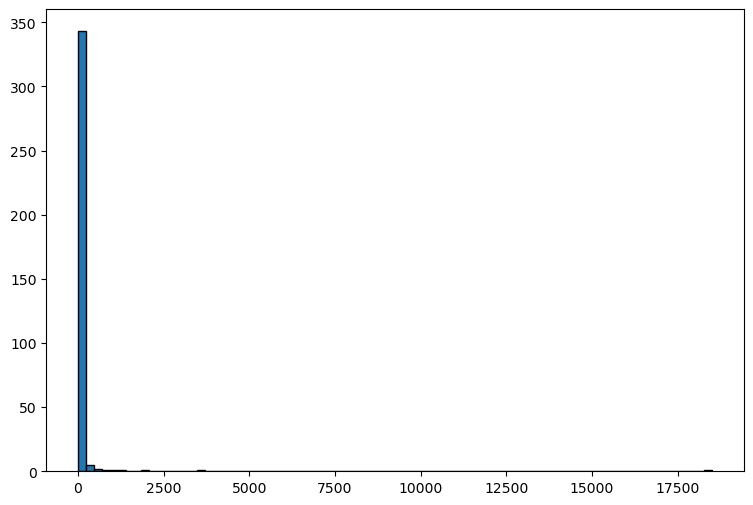

In [12]:
# library & dataset
import matplotlib.pyplot as plt

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 6))

#plot
ax.hist(pd.DataFrame(line_num.values(), columns=['line_num']).value_counts(), bins=80, edgecolor="black")


In [13]:
df = pd.DataFrame(line_num.values(), columns=['line_num']).describe(percentiles=[0.25, 0.5, 0.75, 0.80, 0.90, 0.95])
df

,line_num
count,34031.000000
mean,10.087068
std,33.262733
min,0.000000
25%,1.000000
50%,1.000000
75%,5.000000
80%,7.000000
90%,19.000000
95%,43.000000


In [40]:
df.shape

(34031, 1)

In [14]:
dfg = df.groupby(by='line_num', as_index=False).size()

In [15]:
dfg

,line_num,size
0,0.000000,1
1,1.000000,2
2,5.000000,1
3,7.000000,1
4,10.087068,1
5,19.000000,1
6,33.262733,1
7,43.000000,1
8,751.000000,1
9,34031.000000,1


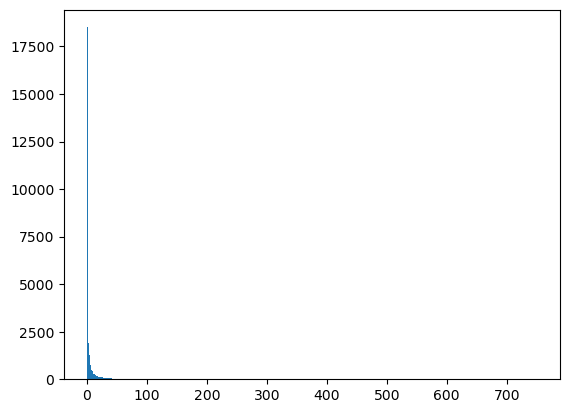

In [53]:
plt.bar(x = dfg['line_num'], height=dfg['size'], )
plt.show()